<h1>Text Analysis - Midterm Cancellation Comments</h1>

<u>Ticket TADA-263</u>

<b>Problem:</b> Currently a number of unclear, informal midterm cancellation comments being bucketed under ‘Other’.

<b>Use case:</b> To perform analysis on customer comments in order to split them into different categories which would help identify the trends that drives midterm cancellation rates. The aim is to not identify what the most prominent cancellation reasons are, but to get more information about midterm cancellations as a whole. 

<b>Deliverable:</b> Python script to execute a machine learning model on new cancellation comments for categorization and analysis. The script could be also included as a Python visualization in PowerBI. 

<h3><b>Dataset Preparation</b></h3>

In [1]:
#imports:
import pandas as pd
import nltk 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
import numpy as np
import pickle


In [2]:
#loading dataset into dataframe
df = pd.read_excel('Random_Sample_wUpdates.xlsx')
df.head() #displays the first 5 rows

,Policy_ID,Cancellation_Comment,Consolidated Reasons,Moderate Classification,Lowest Level Classification
0,3.180667e+16,QSS terminated cancel request effective 12/2/2018,Unknown,NaN,NaN
1,3.180667e+16,this price was higher than quote,Unknown,NaN,NaN
2,3.180667e+16,Rewrite Policy to 1/3MM.,Needed Different Eff Date or Limit,NaN,NaN
3,3.180667e+16,Does not need policy emailed saying he did not...,Change in Coverage Needs,NaN,NaN
4,3.180667e+16,bought another policy,Unknown,NaN,NaN


<h3>Data cleaning</h3>

In [3]:
#uppercase cleaning, converting all text to lowercase
df['CC_lowercase'] = df['Cancellation_Comment'].str.lower()

#punctuation cleaning, removing punctuation
punctuation_signs = list("?:!.,;+&-/<>")
df['CC_punctuation'] = df['CC_lowercase']
for punct_sign in punctuation_signs:
    df['CC_punctuation'] = df['CC_punctuation'].str.replace(punct_sign, '')
    
#pronouns cleaning, removing pronouns
df['CC_pronouns'] = df['CC_punctuation'].str.replace("'s'", "")
df['CC_pronouns1'] = df['CC_pronouns'].str.replace("'t'", "")

#fill null cells
df['CC_fill'] = df['CC_pronouns1'].fillna("")

In [4]:
#Stemming and Lemmatization, converting all text to its origin
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jagaskar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jagaskar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
# lemmatizer 
wordnet_lemmatizer = WordNetLemmatizer()

In [6]:
nrows = len(df)
lemmatized_text_list = []

for row in range(0, nrows):
    
    lemmatized_list = []
    
    text = df.loc[row]['CC_fill']
    text_words = text.split(" ")
    
    for word in text_words: 
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
        
    lemmatized_text = " ".join(lemmatized_list)
    lemmatized_text_list.append(lemmatized_text)

df['CC_lemmatized'] = lemmatized_text_list

In [7]:
#IGNORE this cell, for stop words
nltk.download('stopwords')
stop_words = list(stopwords.words('english'))

df['CC_stop'] = df['CC_lemmatized']

for stop_word in stop_words:
    regex_stopword = r"\b" + stop_word + r"\b"
    df['CC_stop'] = df['CC_lemmatized'].str.replace(regex_stopword, '')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jagaskar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
df.head() #all of the current data cleanup columns 

,Policy_ID,Cancellation_Comment,Consolidated Reasons,Moderate Classification,Lowest Level Classification,CC_lowercase,CC_punctuation,CC_pronouns,CC_pronouns1,CC_fill,CC_lemmatized
0,3.180667e+16,QSS terminated cancel request effective 12/2/2018,Unknown,NaN,NaN,qss terminated cancel request effective 12/2/2018,qss terminated cancel request effective 1222018,qss terminated cancel request effective 1222018,qss terminated cancel request effective 1222018,qss terminated cancel request effective 1222018,qss terminate cancel request effective 1222018
1,3.180667e+16,this price was higher than quote,Unknown,NaN,NaN,this price was higher than quote,this price was higher than quote,this price was higher than quote,this price was higher than quote,this price was higher than quote,this price be higher than quote
2,3.180667e+16,Rewrite Policy to 1/3MM.,Needed Different Eff Date or Limit,NaN,NaN,rewrite policy to 1/3mm.,rewrite policy to 13mm,rewrite policy to 13mm,rewrite policy to 13mm,rewrite policy to 13mm,rewrite policy to 13mm
3,3.180667e+16,Does not need policy emailed saying he did not...,Change in Coverage Needs,NaN,NaN,does not need policy emailed saying he did not...,does not need policy emailed saying he did not...,does not need policy emailed saying he did not...,does not need policy emailed saying he did not...,does not need policy emailed saying he did not...,do not need policy email say he do not authori...
4,3.180667e+16,bought another policy,Unknown,NaN,NaN,bought another policy,bought another policy,bought another policy,bought another policy,bought another policy,buy another policy


In [8]:
#get only necessary columns 
#final prep for data 
list_columns = ["CC_lemmatized", 'Consolidated Reasons']
df = df[list_columns]

df = df.rename(columns={'CC_lemmatized': 'Cancellation_Comments'})

In [9]:
df.head() 

,Cancellation_Comments,Consolidated Reasons
0,qss terminate cancel request effective 1222018,Unknown
1,this price be higher than quote,Unknown
2,rewrite policy to 13mm,Needed Different Eff Date or Limit
3,do not need policy email say he do not authori...,Change in Coverage Needs
4,buy another policy,Unknown


<h3>Category Labeling</h3>

In [10]:
#category codes:

category_code = {
    'Change in Coverage Needs': 0, 
    'Major Life Event': 1, 
    'Needed Different Eff Date or Limit': 2,
    'Product Fit': 3,
    'Unknown': 4,
    'Test': 5
}



In [11]:
#category mapping
df['Category_code'] = df["Consolidated Reasons"]
df = df.replace({'Category_code': category_code})
df

,Cancellation_Comments,Consolidated Reasons,Category_code
0,qss terminate cancel request effective 1222018,Unknown,4
1,this price be higher than quote,Unknown,4
2,rewrite policy to 13mm,Needed Different Eff Date or Limit,2
3,do not need policy email say he do not authori...,Change in Coverage Needs,0
4,buy another policy,Unknown,4
...,...,...,...
377,customer have to cancel policy base on a patie...,Change in Coverage Needs,0
378,purchase policy under the wrong name,Change in Coverage Needs,0
379,cinical be over,Major Life Event,1
380,different carrier,Unknown,4


<h2>Model training</h2>

<h3>Train/Test split</h3>

In [12]:
#test size of 20% 
X_train, X_test, y_train, y_test = train_test_split(df['Cancellation_Comments'], df['Category_code'], test_size=0.20, random_state=8)

In [13]:
#Using TF-IDF: 
#statistically evaluates how relevant a word is to a document in a collection of documents

#parameters: 
ngram_range = (1,2)
min_df = 10
max_df = 1.
max_features = 300

In [14]:
#transform the test set
tfidf = TfidfVectorizer(encoding='utf8', ngram_range=ngram_range,
                       stop_words=None, lowercase=False, max_df=max_df,
                       min_df=min_df, max_features=max_features, norm='l2',
                       sublinear_tf=True)

features_train = tfidf.fit_transform(X_train).toarray()
labels_train=y_train
print(features_train.shape)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)

(305, 55)
(77, 55)


In [15]:
#chi squared test to see which unigrams and bigrams 
#are most correlated with each category

from sklearn.feature_selection import chi2
import numpy as np

for Product, category_id in sorted(category_code.items()):
    features_chi2 = chi2(features_train, labels_train == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}' category:".format(Product))
    print(" . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-5:])))
    print(" . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-2:])))
    print("")

# 'Change in Coverage Needs' category:
 . Most correlated unigrams:
. coverage
. purchase
. have
. limit
. group
 . Most correlated bigrams:
. not need
. longer need

# 'Major Life Event' category:
 . Most correlated unigrams:
. school
. practice
. student
. no
. longer
 . Most correlated bigrams:
. rewrite to
. no longer

# 'Needed Different Eff Date or Limit' category:
 . Most correlated unigrams:
. change
. effective
. higher
. date
. limit
 . Most correlated bigrams:
. new policy
. higher limit

# 'Product Fit' category:
 . Most correlated unigrams:
. by
. want
. she
. be
. insurance
 . Most correlated bigrams:
. higher limit
. do not

# 'Test' category:
 . Most correlated unigrams:
. change
. for
. be
. this
. test
 . Most correlated bigrams:
. rewrite to
. no longer

# 'Unknown' category:
 . Most correlated unigrams:
. limit
. request
. need
. rewrite
. ticket
 . Most correlated bigrams:
. rewrite to
. cancel rewrite



An important note here after the project is that these bigrams and unigrams doesn't necessairly describe each category because we are interested in WHY the customer cancelled, not WHAT. For example, simply "Rewrite" may go into Change in coverage needs but that doesn't tell us why a rewrite so it should go into Unknown. 

<h2>Machine Learning Algorithms</h2>

<h3><u>Random Forest Model</u></h3>

In [16]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#test feature vectors
print(features_train.shape)
print(features_test.shape)

(305, 55)
(77, 55)


In [17]:
#Cross Validation for Hyperparameter tuning

#Parameters: 

# n_estimators
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)] #10

# max_features
max_features = ['auto', 'sqrt']

# max_depth
max_depth = [int(x) for x in np.linspace(20, 100, num = 5)] #10 110 11
max_depth.append(None)

# min_samples_split
min_samples_split = [2, 5, 10]

# min_samples_leaf
min_samples_leaf = [1, 2, 4]

# bootstrap
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [20, 40, 60, 80, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000]}


In [18]:
# Create the base model to tune
rfc = RandomForestClassifier(random_state=8)

random_search = RandomizedSearchCV(estimator=rfc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  2.8min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=8),
                   n_iter=50,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [20, 40, 60, 80, 100,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000]},
                   random_state=8, scoring='accuracy', verbose=1)

In [19]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': False}

The mean accuracy of a model with these hyperparameters is:
0.7181777001229536


In [20]:
#Grid Search CV

bootstrap = [False]
max_depth = [30, 40, 50]
max_features = ['sqrt']
min_samples_leaf = [1, 2, 4]
min_samples_split = [5, 10, 15]
n_estimators = [800]

param_grid = {
    'bootstrap': bootstrap,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators
}

rfc = RandomForestClassifier(random_state=8)

cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

grid_search = GridSearchCV(estimator=rfc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:  1.6min finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             estimator=RandomForestClassifier(random_state=8),
             param_grid={'bootstrap': [False], 'max_depth': [30, 40, 50],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [5, 10, 15],
                         'n_estimators': [800]},
             scoring='accuracy', verbose=1)

In [21]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'bootstrap': False, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 800}

The mean accuracy of a model with these hyperparameters is:
0.6666666666666666


In [22]:
best_rfc = grid_search.best_estimator_
best_rfc

RandomForestClassifier(bootstrap=False, max_depth=30, max_features='sqrt',
                       min_samples_leaf=2, min_samples_split=10,
                       n_estimators=800, random_state=8)

<h3>Random Forest fit and overall performance</h3>

In [23]:
best_rfc.fit(features_train, labels_train)
rfc_pred = best_rfc.predict(features_test)

In [24]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_rfc.predict(features_train)))

# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, rfc_pred))

The training accuracy is: 
0.898360655737705
The test accuracy is: 
0.7012987012987013


In [25]:
# Classification report
print("Classification report")
print(classification_report(labels_test,rfc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.53      0.95      0.68        20
           1       0.67      0.53      0.59        15
           2       0.93      0.93      0.93        14
           3       0.67      0.20      0.31        10
           4       1.00      0.60      0.75        15
           5       1.00      1.00      1.00         3

    accuracy                           0.70        77
   macro avg       0.80      0.70      0.71        77
weighted avg       0.76      0.70      0.69        77



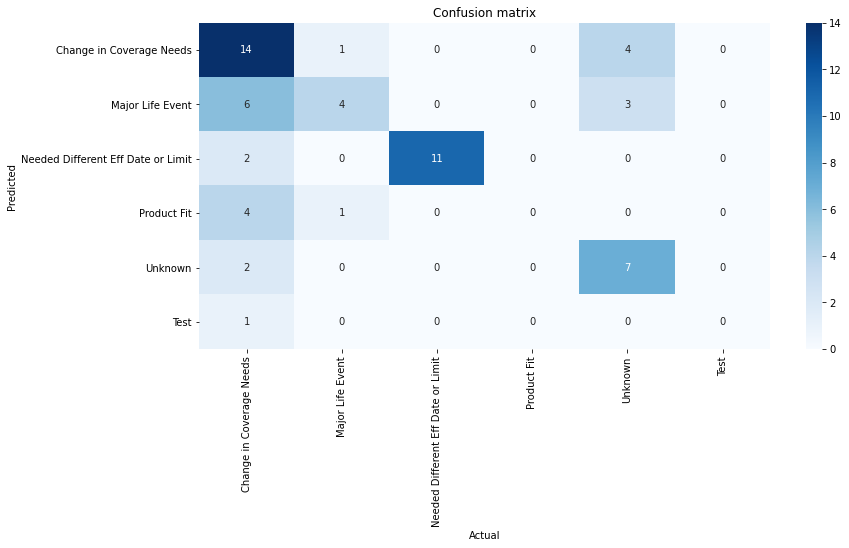

In [252]:
aux_df = df[['Consolidated Reasons', 'Category_code']].drop_duplicates().sort_values('Category_code')
conf_matrix = confusion_matrix(labels_test, rfc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['Consolidated Reasons'].values, 
            yticklabels=aux_df['Consolidated Reasons'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [31]:
d = {
     'Model': 'Random Forest',
     'Training Set Accuracy': accuracy_score(labels_train, best_rfc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(labels_test, rfc_pred)
}

df_models_rfc = pd.DataFrame(d, index=[0])

df_models_rfc

,Model,Training Set Accuracy,Test Set Accuracy
0,Random Forest,0.898361,0.701299


In [32]:
with open('Pickles/best_rfc.pickle','wb') as output:
    pickle.dump(best_rfc, output)

<h1>Support Vector Machine (SVM)</h1>

In [28]:
#Cross-Validation for Hyperparameter tuning 

#Parameters:

# C
C = [.0001, .001, .01]

# gamma
gamma = [.0001, .001, .01, .1, 1, 10, 100]

# degree
degree = [1, 2, 3, 4, 5]

# kernel
kernel = ['linear', 'rbf', 'poly']

# probability
probability = [True]

# Create the random grid
random_grid = {'C': C,
              'kernel': kernel,
              'gamma': gamma,
              'degree': degree,
              'probability': probability
             }

pprint(random_grid)

{'C': [0.0001, 0.001, 0.01],
 'degree': [1, 2, 3, 4, 5],
 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
 'kernel': ['linear', 'rbf', 'poly'],
 'probability': [True]}


In [29]:
from sklearn import svm

# Random search CV:

svc = svm.SVC(random_state=8)

random_search = RandomizedSearchCV(estimator=svc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    4.4s finished


RandomizedSearchCV(cv=3, estimator=SVC(random_state=8), n_iter=50,
                   param_distributions={'C': [0.0001, 0.001, 0.01],
                                        'degree': [1, 2, 3, 4, 5],
                                        'gamma': [0.0001, 0.001, 0.01, 0.1, 1,
                                                  10, 100],
                                        'kernel': ['linear', 'rbf', 'poly'],
                                        'probability': [True]},
                   random_state=8, scoring='accuracy', verbose=1)

In [30]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'probability': True, 'kernel': 'poly', 'gamma': 10, 'degree': 4, 'C': 0.01}

The mean accuracy of a model with these hyperparameters is:
0.5178929657671649


In [31]:
#Grid Search CV 

C = [.0001, .001, .01, .1]
degree = [3, 4, 5]
gamma = [1, 10, 100]
probability = [True]

param_grid = [
  {'C': C, 'kernel':['linear'], 'probability':probability},
  {'C': C, 'kernel':['poly'], 'degree':degree, 'probability':probability},
  {'C': C, 'kernel':['rbf'], 'gamma':gamma, 'probability':probability}
]

svc = svm.SVC(random_state=8)

cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

grid_search = GridSearchCV(estimator=svc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:    2.4s finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             estimator=SVC(random_state=8),
             param_grid=[{'C': [0.0001, 0.001, 0.01, 0.1], 'kernel': ['linear'],
                          'probability': [True]},
                         {'C': [0.0001, 0.001, 0.01, 0.1], 'degree': [3, 4, 5],
                          'kernel': ['poly'], 'probability': [True]},
                         {'C': [0.0001, 0.001, 0.01, 0.1],
                          'gamma': [1, 10, 100], 'kernel': ['rbf'],
                          'probability': [True]}],
             scoring='accuracy', verbose=1)

In [32]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'C': 0.1, 'kernel': 'linear', 'probability': True}

The mean accuracy of a model with these hyperparameters is:
0.42244224422442245


In [33]:
best_svc = grid_search.best_estimator_
best_svc

SVC(C=0.1, kernel='linear', probability=True, random_state=8)

<h3>SVM fit and overall performance</h3>

In [34]:
best_svc.fit(features_train, labels_train)

SVC(C=0.1, kernel='linear', probability=True, random_state=8)

In [35]:
svc_pred = best_svc.predict(features_test)

In [36]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_svc.predict(features_train)))

# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, svc_pred))

The training accuracy is: 
0.5377049180327869
The test accuracy is: 
0.4155844155844156


In [37]:
base_model = svm.SVC(random_state = 8)
base_model.fit(features_train, labels_train)
accuracy_score(labels_test, base_model.predict(features_test))

best_svc.fit(features_train, labels_train)
accuracy_score(labels_test, best_svc.predict(features_test))

0.4155844155844156

In [38]:
d = {
     'Model': 'SVM',
     'Training Set Accuracy': accuracy_score(labels_train, best_svc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(labels_test, svc_pred)
}

df_models_svc = pd.DataFrame(d, index=[0])
df_models_svc

,Model,Training Set Accuracy,Test Set Accuracy
0,SVM,0.537705,0.415584


<u>Notes: </u>
<p>In this model example, I will not going forth with SVM because of its poor performance.</p>
<p>However, this is Linear SVM. I may try out Kernel SVM </p>
<p>I preformed K=Nearest Neighbors (KNN) and had trouble: less number of samples than neighbors, the dataset is too small, so I will not be moving forward with that as well.</p>

<h1>Multinomial Naive Bayes</h1>

In [39]:
from sklearn.naive_bayes import MultinomialNB

#Cross-Validation for Hyperparameter tuning 

mnbc = MultinomialNB()

mnbc.fit(features_train, labels_train)
mnbc_pred = mnbc.predict(features_test)

In [40]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, mnbc.predict(features_train)))

# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, mnbc_pred))

The training accuracy is: 
0.7180327868852459
The test accuracy is: 
0.5714285714285714


In [41]:
# Classification report
print("Classification report")
print(classification_report(labels_test,mnbc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.40      0.85      0.54        20
           1       0.83      0.33      0.48        15
           2       0.72      0.93      0.81        14
           3       1.00      0.20      0.33        10
           4       0.88      0.47      0.61        15
           5       0.00      0.00      0.00         3

    accuracy                           0.57        77
   macro avg       0.64      0.46      0.46        77
weighted avg       0.70      0.57      0.54        77



C:\Users\jagaskar\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


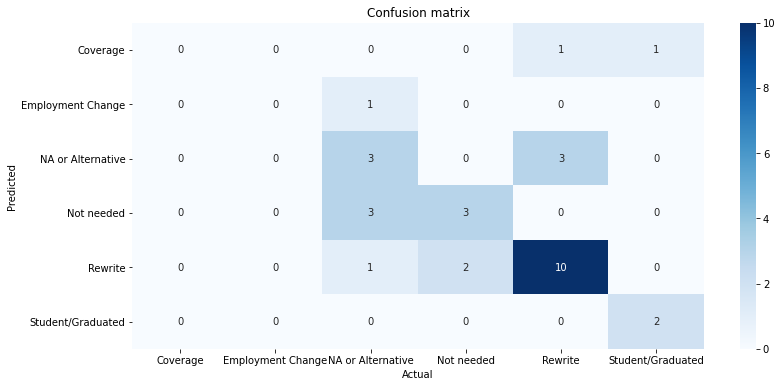

In [48]:
aux_df = df[['Gwens_Categorization_2', 'Category_code']].drop_duplicates().sort_values('Category_code')
conf_matrix = confusion_matrix(labels_test, mnbc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['Gwens_Categorization_2'].values, 
            yticklabels=aux_df['Gwens_Categorization_2'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [42]:
d = {
     'Model': 'Multinomial Naïve Bayes',
     'Training Set Accuracy': accuracy_score(labels_train, mnbc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(labels_test, mnbc_pred)
}

df_models_mnbc = pd.DataFrame(d, index=[0])
df_models_mnbc

,Model,Training Set Accuracy,Test Set Accuracy
0,Multinomial Naïve Bayes,0.718033,0.571429


<h1>Multinomial Logistic Regression</h1>
<h3>Cross-Validation for Hyperparameter tuning</h3>

In [43]:
from sklearn.linear_model import LogisticRegression

lr_0 = LogisticRegression(random_state = 8)

print('Parameters currently in use:\n')
pprint(lr_0.get_params())

Parameters currently in use:

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 8,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


In [44]:
#Randomized Search CV

#Parameters:

# C
C = [float(x) for x in np.linspace(start = 0.1, stop = 1, num = 10)]

# multi_class
multi_class = ['multinomial']

# solver
solver = ['newton-cg', 'sag', 'saga', 'lbfgs']
 
# class_weight
class_weight = ['balanced', None]

# penalty
penalty = ['l2']

# Create the random grid
random_grid = {'C': C,
               'multi_class': multi_class,
               'solver': solver,
               'class_weight': class_weight,
               'penalty': penalty}

pprint(random_grid)

{'C': [0.1,
       0.2,
       0.30000000000000004,
       0.4,
       0.5,
       0.6,
       0.7000000000000001,
       0.8,
       0.9,
       1.0],
 'class_weight': ['balanced', None],
 'multi_class': ['multinomial'],
 'penalty': ['l2'],
 'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']}


In [45]:

lrc = LogisticRegression(random_state=8)

random_search = RandomizedSearchCV(estimator=lrc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\jagaskar\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\jagaskar\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\jagaskar\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\jagaskar\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\jagaskar\Anaconda3\lib\site-pa

RandomizedSearchCV(cv=3, estimator=LogisticRegression(random_state=8),
                   n_iter=50,
                   param_distributions={'C': [0.1, 0.2, 0.30000000000000004,
                                              0.4, 0.5, 0.6, 0.7000000000000001,
                                              0.8, 0.9, 1.0],
                                        'class_weight': ['balanced', None],
                                        'multi_class': ['multinomial'],
                                        'penalty': ['l2'],
                                        'solver': ['newton-cg', 'sag', 'saga',
                                                   'lbfgs']},
                   random_state=8, scoring='accuracy', verbose=1)

In [46]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'solver': 'lbfgs', 'penalty': 'l2', 'multi_class': 'multinomial', 'class_weight': 'balanced', 'C': 0.6}

The mean accuracy of a model with these hyperparameters is:
0.6885394421795121


In [47]:
#Grid Search CV

C = [float(x) for x in np.linspace(start = 0.6, stop = 1, num = 10)]
multi_class = ['multinomial']
solver = ['sag']
class_weight = ['balanced']
penalty = ['l2']

param_grid = {'C': C,
               'multi_class': multi_class,
               'solver': solver,
               'class_weight': class_weight,
               'penalty': penalty}

lrc = LogisticRegression(random_state=8)

cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

grid_search = GridSearchCV(estimator=lrc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\jagaskar\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\jagaskar\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\jagaskar\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\jagaskar\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\jagaskar\Anaconda3\lib\site-pa

GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             estimator=LogisticRegression(random_state=8),
             param_grid={'C': [0.6, 0.6444444444444444, 0.6888888888888889,
                               0.7333333333333333, 0.7777777777777778,
                               0.8222222222222222, 0.8666666666666667,
                               0.9111111111111111, 0.9555555555555555, 1.0],
                         'class_weight': ['balanced'],
                         'multi_class': ['multinomial'], 'penalty': ['l2'],
                         'solver': ['sag']},
             scoring='accuracy', verbose=1)

In [48]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'C': 0.7333333333333333, 'class_weight': 'balanced', 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'sag'}

The mean accuracy of a model with these hyperparameters is:
0.6732673267326733


In [49]:
best_lrc = grid_search.best_estimator_
best_lrc

LogisticRegression(C=0.7333333333333333, class_weight='balanced',
                   multi_class='multinomial', random_state=8, solver='sag')

In [50]:
best_lrc.fit(features_train, labels_train)
lrc_pred = best_lrc.predict(features_test)

C:\Users\jagaskar\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


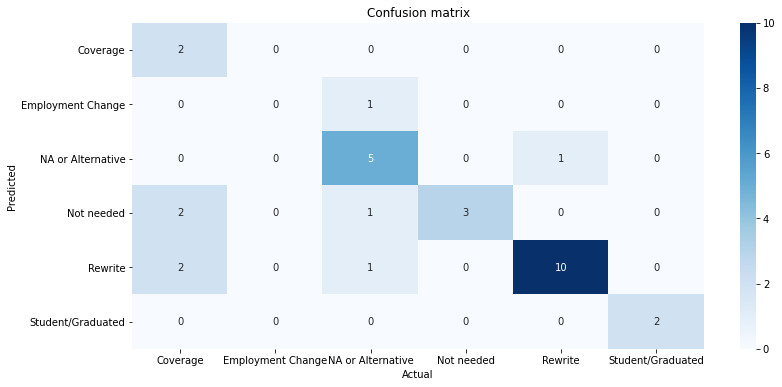

In [50]:
aux_df = df[['Gwens_Categorization_2', 'Category_code']].drop_duplicates().sort_values('Category_code')
conf_matrix = confusion_matrix(labels_test, lrc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['Gwens_Categorization_2'].values, 
            yticklabels=aux_df['Gwens_Categorization_2'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [51]:
base_model = LogisticRegression(random_state = 8)
base_model.fit(features_train, labels_train)
accuracy_score(labels_test, base_model.predict(features_test))

0.6103896103896104

In [52]:
best_lrc.fit(features_train, labels_train)
accuracy_score(labels_test, best_lrc.predict(features_test))

C:\Users\jagaskar\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


0.6623376623376623

In [53]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_lrc.predict(features_train)))

# Testing accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, lrc_pred))

The training accuracy is: 
0.7540983606557377
The test accuracy is: 
0.6623376623376623


In [54]:
d = {
     'Model': 'Logistic Regression',
     'Training Set Accuracy': accuracy_score(labels_train, best_lrc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(labels_test, lrc_pred)
}

df_models_lrc = pd.DataFrame(d, index=[0])
df_models_lrc

,Model,Training Set Accuracy,Test Set Accuracy
0,Logistic Regression,0.754098,0.662338


<h1>Gradient Boosting Machine</h1> 

<h3>Cross-Validation for Hyperparameter Tuning</h3>

In [55]:
from sklearn.ensemble import GradientBoostingClassifier

gb_0 = GradientBoostingClassifier(random_state = 8)

print('Parameters currently in use:\n')
pprint(gb_0.get_params())

Parameters currently in use:

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': 8,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


In [56]:
#Randomized Search CV

#Parameters: 

# n_estimators
n_estimators = [200, 800]

# max_features
max_features = ['auto', 'sqrt']

# max_depth
max_depth = [10, 40]
max_depth.append(None)

# min_samples_split
min_samples_split = [10, 30, 50]

# min_samples_leaf
min_samples_leaf = [1, 2, 4]

# learning rate
learning_rate = [.1, .5]

# subsample
subsample = [.5, 1.]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'learning_rate': learning_rate,
               'subsample': subsample}

pprint(random_grid)

{'learning_rate': [0.1, 0.5],
 'max_depth': [10, 40, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [10, 30, 50],
 'n_estimators': [200, 800],
 'subsample': [0.5, 1.0]}


In [57]:
gbc = GradientBoostingClassifier(random_state=8)

random_search = RandomizedSearchCV(estimator=gbc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 19.7min finished


RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=8),
                   n_iter=50,
                   param_distributions={'learning_rate': [0.1, 0.5],
                                        'max_depth': [10, 40, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [10, 30, 50],
                                        'n_estimators': [200, 800],
                                        'subsample': [0.5, 1.0]},
                   random_state=8, scoring='accuracy', verbose=1)

In [58]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'subsample': 1.0, 'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40, 'learning_rate': 0.5}

The mean accuracy of a model with these hyperparameters is:
0.6918721283893096


In [59]:
#Grid Search CV

max_depth = [5, 10, 15]
max_features = ['sqrt']
min_samples_leaf = [2]
min_samples_split = [50, 100]
n_estimators = [800]
learning_rate = [.1, .5]
subsample = [1.]

param_grid = {
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators,
    'learning_rate': learning_rate,
    'subsample': subsample

}

gbc = GradientBoostingClassifier(random_state=8)

cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

grid_search = GridSearchCV(estimator=gbc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  3.3min finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             estimator=GradientBoostingClassifier(random_state=8),
             param_grid={'learning_rate': [0.1, 0.5], 'max_depth': [5, 10, 15],
                         'max_features': ['sqrt'], 'min_samples_leaf': [2],
                         'min_samples_split': [50, 100], 'n_estimators': [800],
                         'subsample': [1.0]},
             scoring='accuracy', verbose=1)

In [60]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 100, 'n_estimators': 800, 'subsample': 1.0}

The mean accuracy of a model with these hyperparameters is:
0.6369636963696369


In [61]:
best_gbc = grid_search.best_estimator_
best_gbc

GradientBoostingClassifier(max_depth=5, max_features='sqrt', min_samples_leaf=2,
                           min_samples_split=100, n_estimators=800,
                           random_state=8)

In [62]:
best_gbc.fit(features_train, labels_train)

GradientBoostingClassifier(max_depth=5, max_features='sqrt', min_samples_leaf=2,
                           min_samples_split=100, n_estimators=800,
                           random_state=8)

In [63]:
gbc_pred = best_gbc.predict(features_test)

In [64]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_gbc.predict(features_train)))

# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, gbc_pred))

The training accuracy is: 
0.9442622950819672
The test accuracy is: 
0.5454545454545454


In [65]:
# Classification report
print("Classification report")
print(classification_report(labels_test,gbc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.42      0.65      0.51        20
           1       0.27      0.20      0.23        15
           2       0.92      0.86      0.89        14
           3       0.33      0.40      0.36        10
           4       1.00      0.47      0.64        15
           5       1.00      1.00      1.00         3

    accuracy                           0.55        77
   macro avg       0.66      0.60      0.60        77
weighted avg       0.61      0.55      0.55        77



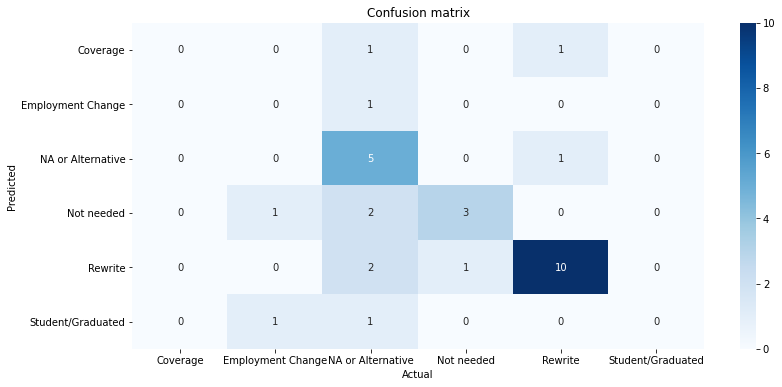

In [74]:
aux_df = df[['Gwens_Categorization_2', 'Category_code']].drop_duplicates().sort_values('Category_code')
conf_matrix = confusion_matrix(labels_test, gbc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['Gwens_Categorization_2'].values, 
            yticklabels=aux_df['Gwens_Categorization_2'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [66]:
base_model = GradientBoostingClassifier(random_state = 8)
base_model.fit(features_train, labels_train)
accuracy_score(labels_test, base_model.predict(features_test))

0.6493506493506493

In [67]:
best_gbc.fit(features_train, labels_train)
accuracy_score(labels_test, best_gbc.predict(features_test))

0.5454545454545454

In [68]:
d = {
     'Model': 'Gradient Boosting',
     'Training Set Accuracy': accuracy_score(labels_train, best_gbc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(labels_test, gbc_pred)
}

df_models_gbc = pd.DataFrame(d, index=[0])
df_models_gbc

,Model,Training Set Accuracy,Test Set Accuracy
0,Gradient Boosting,0.944262,0.545455


<h1>Overall Performances of ML Models</h1>

In [69]:
df_summary = pd.DataFrame()

model_list = [df_models_rfc, df_models_mnbc, df_models_lrc, df_models_gbc, df_models_svc]

for model in model_list: 
    df_summary = df_summary.append(model)

df_summary = df_summary.reset_index().drop('index', axis=1)


df_summary.sort_values('Test Set Accuracy', ascending=True)
df_summary

,Model,Training Set Accuracy,Test Set Accuracy
0,Random Forest,0.898361,0.701299
1,Multinomial Naïve Bayes,0.718033,0.571429
2,Logistic Regression,0.754098,0.662338
3,Gradient Boosting,0.944262,0.545455
4,SVM,0.537705,0.415584


Based on results table, the Gradient Boosting algorithm has the highest training accuracy of 0.9 whilst and Random Forest has the highest testing accuracy. However, because Gradient Boosting's training set accuracy is much higher than its testing set, this means the algorithm suffers from overfitting: the model will not perform as well with new data. Therefore, Random Forest model has overall highest training and testing set accuracies. So we'll be going forth with Random Forest.

<h2>Sample Comments Testing</h2>

In [36]:
#a function to clean sample text

from nltk.corpus import stopwords

punctuation_signs = list("?:!.,;+&-/<>")
stop_words = list(stopwords.words('english'))

def create_features_from_text(text):
    
    # Dataframe creation
    lemmatized_text_list = []
    df = pd.DataFrame(columns=['Content'])
    df.loc[0] = text
    df['Content_Parsed_1'] = df['Content'].str.replace("\r", " ")
    df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace("\n", " ")
    df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace("    ", " ")
    df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace('"', '')
    df['Content_Parsed_2'] = df['Content_Parsed_1'].str.lower()
    df['Content_Parsed_3'] = df['Content_Parsed_2']
    for punct_sign in punctuation_signs:
        df['Content_Parsed_3'] = df['Content_Parsed_3'].str.replace(punct_sign, '')
    df['Content_Parsed_4'] = df['Content_Parsed_3'].str.replace("'s", "")
    df['Content_Parsed_5'] = df['Content_Parsed_4'].fillna("")
    wordnet_lemmatizer = WordNetLemmatizer()
    lemmatized_list = []
    text = df.loc[0]['Content_Parsed_5']
    text_words = text.split(" ")
    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
    lemmatized_text = " ".join(lemmatized_list)    
    lemmatized_text_list.append(lemmatized_text)
    df['Content_Parsed_6'] = lemmatized_text_list
    df['Content_Parsed_7'] = df['Content_Parsed_6']
    for stop_word in stop_words:
        regex_stopword = r"\b" + stop_word + r"\b"
        df['Content_Parsed_8'] = df['Content_Parsed_7'].str.replace(regex_stopword, '')
    df = df['Content_Parsed_8']
   # df = df.rename(columns={'Content_Parsed_7': 'Content_Parsed'})

    # TF-IDF
    features = tfidf.transform(df).toarray()
    
    return features

In [37]:
# to return category from the category_code list

def get_category_name(category_id):
    for category, id_ in category_code.items():    
        if id_ == category_id:
            return category

In [41]:
def predict_from_text(text):
    
    # Predict using the input model
    prediction_rfc = best_rfc.predict(create_features_from_text(text))[0]
    prediction_rfc_proba = best_rfc.predict_proba(create_features_from_text(text))[0]
    
    # Return result
    category_rfc = get_category_name(prediction_rfc)
    
    print("The predicted category using the Random Forest model is %s." %(category_rfc) )
    print("The conditional probability is: %a" %(prediction_rfc_proba.max()*100))

In [44]:
text = """
this is a testing comment!

"""


In [45]:
predict_from_text(text)

The predicted category using the Random Forest model is Test.
The conditional probability is: 83.57115222442285


In [33]:
#SAVING AS PICKLES

In [35]:
with open('Pickles/X_train.pickle', 'wb') as output:
    pickle.dump(X_train, output)
    
with open('Pickles/X_test.pickle', 'wb') as output:
    pickle.dump(X_test, output)
    
with open('Pickles/y_train.pickle', 'wb') as output:
    pickle.dump(y_train, output)
    
with open('Pickles/y_test.pickle', 'wb') as output:
    pickle.dump(y_test, output)
    
with open('Pickles/features_train.pickle', 'wb') as output:
    pickle.dump(features_train, output)
    
with open('Pickles/labels_train.pickle', 'wb') as output:
    pickle.dump(labels_train, output)
    
with open('Pickles/features_test.pickle', 'wb') as output:
    pickle.dump(features_test, output)
    
with open('Pickles/labels_test.pickle', 'wb') as output:
    pickle.dump(labels_test, output)
    
with open('Pickles/tfidf.pickle', 'wb') as output:
    pickle.dump(tfidf, output)